<a href="https://colab.research.google.com/github/RoyElkabetz/Text-Summarization-with-Deep-Learning/blob/main/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Text-Summarization-with-Deep-Learning
# add path to .py files for import
import sys
sys.path.insert(1, "/content/Text-Summarization-with-Deep-Learning")

Cloning into 'Text-Summarization-with-Deep-Learning'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 131 (delta 75), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (131/131), 234.27 KiB | 9.01 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [2]:
## uncomment if you want to mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [76]:
PATH_DATASET = '/content/gdrive/MyDrive/Datasets/Text/news_summary_more.csv'
CHECKPOINT_DIR = '/content/gdrive/MyDrive/Checkpoints'
MODEL_NAME = 'LSTM_Text_Summarizer'

In [77]:
%matplotlib inline
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output
from tqdm.autonotebook import tqdm


import torch
from torch import nn
import torchtext.legacy.data as data
from torchtext.data.utils import get_tokenizer
from torchtext.legacy.data import Field, Dataset, Example, BucketIterator, Iterator
from torch.utils.data import DataLoader, random_split

# from torchtext.datasets import IMDB as the_dataset
# from torchtext.datasets import AG_NEWS as the_dataset
# import torchtext.data as data
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator
# from torchtext.data.functional import to_map_style_dataset
# from torch.utils.data import DataLoader
# from torch.utils.data.dataset import random_split
# from torch import nn




print(f'torch {torch.__version__}')
print('Device properties:')
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_data = torch.cuda.get_device_properties(0)
    gpu_name = gpu_data.name
    gpu_mem  = f'{gpu_data.total_memory * 1e-9:.02f} Gb'
    print(f'GPU: {gpu_name}\nMemory: {gpu_mem}')
else:
    device = torch.device("cpu")
    print('CPU')

torch 1.9.0+cu102
Device properties:
GPU: Tesla T4
Memory: 15.84 Gb


In [78]:
class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""
    """Pytorch legacy Dataset: https://pytorch.org/text/_modules/torchtext/data/dataset.html"""
    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.examples = examples.apply(SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        self.fields = dict(fields)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""
  
    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()
        
        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [126]:
data_df = pd.read_csv(PATH_DATASET ,encoding='utf-8')
data_df.drop_duplicates(subset=['text'],inplace=True)  # dropping duplicates
data_df.dropna(axis=0,inplace=True)  # dropping na
data_df.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [127]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [128]:
## run this if you want to remove stop words from data
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower() # lowercase
    text = text.split() # convert have'nt -> have not
    for i in range(len(text)):
        word = text[i]
        if word in contraction_mapping:
            text[i] = contraction_mapping[word]
    text = " ".join(text)
    # text = text.split()
    # newtext = []
    # for word in text:
    #     if word not in stop_words:
    #         newtext.append(word)
    # text = " ".join(newtext)
    # text = text.replace("'s",'') # convert your's -> your
    #text = re.sub(r'\(.*\)','',text) # remove (words)
    #text = re.sub(r'[^a-zA-Z0-9. ]','',text) # remove punctuations
    #text = re.sub(r'\.',' . ',text)
    return text

sample = "(hello) hi there .man tiger caller who's that isn't it ? WALL-E"
print(preprocess(sample))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(hello) hi there .man tiger caller who is that is not it ? wall-e


In [129]:
# process the data inplace
print('Before preprocessing:\n {}\n {}\n'.format(data_df['headlines'][20], data_df['text'][20]))
data_df['cleaned_headlines'] = data_df['headlines'].apply(lambda x: preprocess(x))
data_df['cleaned_text'] = data_df['text'].apply(lambda x: preprocess(x))
print('After preprocessing:\n {}\n {}\n'.format(data_df['headlines'][20], data_df['text'][20]))
print('After preprocessing:\n {}\n {}\n'.format(data_df['cleaned_headlines'][20], data_df['cleaned_text'][20]))

Before preprocessing:
 I think the opposition even dreams about me: PM Modi
 Claiming there is a dearth of ideas among opposition parties, Prime Minister Narendra Modi on Wednesday said, "The opposition talks only about Modi the whole day, I suspect they even dream about me." PM Modi, who was addressing the New India Youth Conclave inâ Surat, added that the opposition parties have only one agenda which is "Modi". 

After preprocessing:
 I think the opposition even dreams about me: PM Modi
 Claiming there is a dearth of ideas among opposition parties, Prime Minister Narendra Modi on Wednesday said, "The opposition talks only about Modi the whole day, I suspect they even dream about me." PM Modi, who was addressing the New India Youth Conclave inâ Surat, added that the opposition parties have only one agenda which is "Modi". 

After preprocessing:
 i think the opposition even dreams about me: pm modi
 claiming there is a dearth of ideas among opposition parties, prime minister narend

In [130]:
data_df.replace('', np.nan, inplace=True)
data_df.dropna(axis=0, inplace=True)

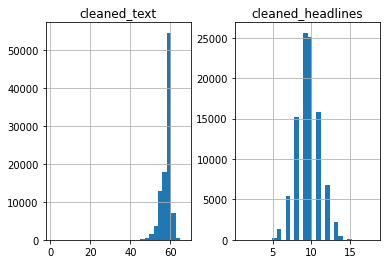

In [131]:
text_word_count = []
headlines_word_count = []

# populate the lists with sentence lengths
for i in data_df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data_df['cleaned_headlines']:
      headlines_word_count.append(len(i.split()))


length_df = pd.DataFrame({'cleaned_text':text_word_count, 'cleaned_headlines':headlines_word_count})
length_df.hist(bins = 30)
plt.show()

In [132]:
cnt = 0
for i in data_df['cleaned_headlines']:
    if(len(i.split()) <= 15):
        cnt += 1
print(cnt / len(data_df['cleaned_headlines']))

cnt = 0
for i in data_df['cleaned_text']:
    if(len(i.split()) <= 65):
        cnt += 1
print(cnt / len(data_df['cleaned_text']))

0.9997559983733225
0.9999186661244408


In [133]:
max_text_len = 65
max_summary_len = 15
pad_token = ' <pad>'

In [137]:
cleaned_text = np.array(data_df['cleaned_text'])
cleaned_summary = np.array(data_df['cleaned_headlines'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len):
        #padded_cleaned_text = cleaned_text[i] + (max_text_len - len(cleaned_text[i].split())) * pad_token
        #padded_cleaned_summary = cleaned_summary[i] + (max_summary_len - len(cleaned_summary[i].split())) * pad_token
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df = pd.DataFrame({'text': short_text,'summary': short_summary})
print(len(df))

98328


In [138]:
tokenizer = get_tokenizer("basic_english")

# define the text field for the dataset
TEXT = data.Field(sequential=True,
                  lower=True, 
                  tokenize=tokenizer,
                  init_token='<sos>', 
                  eos_token='<eos>',
                  dtype=torch.long)
# define the text field for the dataset
SUMMARY = data.Field(sequential=True,
                    lower=True, 
                    tokenize=tokenizer,
                    init_token='<sos>', 
                    eos_token='<eos>',
                    dtype=torch.long)
#SUMMARY = data.Field(sequential=True, tokenize=tokenizer)
# TEXT.build_vocab(my_data, max_size=25000, vectors="glove.6B.100d") 
#TEXT.build_vocab(my_data, max_size=25000) 
#SUMMARY.build_vocab(my_data)
fields = {'text': TEXT, 'summary': SUMMARY}

In [139]:
train_data, test_data, val_data = DataFrameDataset(df, fields=fields).split(split_ratio=[0.8, 0.1, 0.1])

In [140]:
TEXT.build_vocab(train_data, min_freq=2)
SUMMARY.build_vocab(train_data, min_freq=2) 

vocab = TEXT.vocab
print(f"Unique tokens in training text vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in training summary vocabulary: {len(SUMMARY.vocab)}")

Unique tokens in training text vocabulary: 53927
Unique tokens in training summary vocabulary: 22260


In [141]:
print(f'Number of train samples: {len(train_data)}')
print(f'Number of validation samples: {len(val_data)}')
print(f'Number of test samples: {len(test_data)}')

# display data samples
display(HTML('<h4>Display data samples:</h4>'))
n_samples = 2
for i in range(n_samples):
    print("\nText:\n ", " ".join([t for t in train_data.examples[i].text]))
    print("Tokens:\n ", [vocab.stoi[t] for t in train_data.examples[i].text])
    print("Summary:\n ", " ".join([t for t in train_data.examples[i].summary]))
    print("Tokens:\n ", [vocab.stoi[t] for t in train_data.examples[i].summary])

Number of train samples: 78662
Number of validation samples: 9833
Number of test samples: 9833



Text:
  opera software has created a new version of its internet browser codenamed ' reborn ' with a messaging sidebar built directly into the interface . the sidebar gives users direct access to facebook-owned whatsapp and messenger apps instead of using web or desktop versions . users will be able to pin chats next to their open tabs or pin the icons to the sidebar .
Tokens:
  [12758, 1373, 15, 809, 8, 79, 1598, 11, 47, 1071, 6547, 11970, 10, 39125, 10, 23, 8, 2801, 39655, 1137, 2320, 98, 4, 7310, 5, 4, 39655, 2483, 180, 1640, 947, 7, 4777, 974, 12, 4783, 1979, 716, 11, 249, 2146, 95, 9553, 6926, 5, 180, 29, 32, 821, 7, 9112, 8342, 281, 7, 52, 358, 26846, 95, 9112, 4, 10313, 7, 4, 39655, 5]
Summary:
  opera makes web browser with built-in whatsapp , fb messenger
Tokens:
  [12758, 1453, 2146, 6547, 23, 7968, 974, 6, 36505, 4783]

Text:
  tata sky has dropped over 20 channels run by sony pictures networks , including sab and max along with three tv today network channels like aaj tak 

In [142]:
print(vars(train_data.examples[0])['summary'])
print([SUMMARY.vocab.stoi[t] for t in vars(train_data.examples[0])['summary']])

['opera', 'makes', 'web', 'browser', 'with', 'built-in', 'whatsapp', ',', 'fb', 'messenger']
[8498, 306, 1788, 6593, 12, 9537, 428, 7, 313, 4362]


In [147]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, val_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    shuffle=False,
    sort=False
    )

In [148]:
for i, batch in enumerate(train_iterator):
    trg = batch.summary
    if i==0:
        print(trg.shape)
    else:
      break
        

torch.Size([17, 64])


In [149]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        # initializations
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # we will use 2 layers for both encoder and decoder
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        embedded = self.dropout(self.embedding(src)) # [src len, batch size]
        outputs, (hidden, cell) = self.rnn(embedded) # [src len, batch size, emb dim]
        
        ## dimension
        # outputs = [src len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        # outputs are always from the top hidden layer
        return hidden, cell
 



class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hid dim]
        # context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0) #  [1, batch size]
        embedded = self.dropout(self.embedding(input)) #  [1, batch size, emb dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        # output = [seq len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0)) #  [batch size, output dim]
        
        return prediction, hidden, cell

    

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        # src = [src len, batch size]
        # trg = [trg len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        
        for t in range(1, trg_len):
            
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [150]:
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(SUMMARY.vocab)
ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
HID_DIM = 64
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# initialize seq2seq model
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device)

In [154]:
class Seq2Seq_trainer(object):
    def __init__(self, model, train_iterator, valid_iterator, pad_index, device, clip, learning_rate):
        # initialize config variables
        self.model = model.to(device)
        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator
        self.clip = clip
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        # TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
        self.criterion = nn.CrossEntropyLoss(ignore_index = pad_index)
        self.model.apply(self.init_weights)
        self.logger = {'training_loss': [], 
                       'validation_loss': [],
                       'epochs': [],
                       }
        print(f'The model has {self.count_parameters(self.model):,} trainable parameters')

        
    
    def init_weights(self,m):
        for name, param in m.named_parameters():
            nn.init.uniform_(param.data, -0.08, 0.08)
        
    
    def count_parameters(self, model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    
    def train(self):

        self.model.train()
        epoch_loss = 0
        for i, batch in enumerate(self.train_iterator):

            src = batch.text
            trg = batch.summary
            self.optimizer.zero_grad()
            output = self.model(src, trg)

            # trg = [trg len, batch size]
            # output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            # trg = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]

            loss = self.criterion(output, trg)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)
            self.optimizer.step()
            epoch_loss += loss.item()

        return epoch_loss / len(self.train_iterator)
    
    
    def evaluate(self, iterator):

        self.model.eval()
        epoch_loss = 0

        with torch.no_grad():
            for i, batch in enumerate(iterator):

                src = batch.text
                trg = batch.summary
                output = self.model(src, trg, teacher_forcing_ratio=0) #turn off teacher forcing

                # trg = [trg len, batch size]
                # output = [trg len, batch size, output dim]

                output_dim = output.shape[-1]
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)

                # trg = [(trg len - 1) * batch size]
                # output = [(trg len - 1) * batch size, output dim]

                loss = self.criterion(output, trg)
                epoch_loss += loss.item()

        return epoch_loss / len(iterator)
    
    
    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs
    
    
    def fit(self, nepochs):
        best_valid_loss = float('inf')
        best_model = None
        epoch_counter = 0

        for epoch in tqdm(range(nepochs)):
            if epoch_counter == 5:
                torch.save(state, f'{CHECKPOINT_DIR}/{MODEL_NAME}_{epoch}.pth')
                print('-' * 89)
                print('| Model was saved |')
                print('-' * 89)
                epoch_counter = 0
                
            start_time = time.time()
            train_loss = self.train()
            valid_loss = self.evaluate(self.valid_iterator)
            end_time = time.time()
            epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

            self.logger['training_loss'].append(train_loss)
            self.logger['validation_loss'].append(valid_loss)
            self.logger['epochs'].append(epoch)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                state = {
                    'model': self.model.state_dict(),
                    'epoch': epoch,
                    'logger': self.logger
                }
                torch.save(state, f'{CHECKPOINT_DIR}/{MODEL_NAME}_{epoch}.pth')
                print('-' * 89)
                print('| Model was saved |')
                print('-' * 89)

                # torch.save(model.state_dict(), 'tut1-model.pt')
                print(f'Epoch with best validation loss: {epoch+1:02}')
                epoch_counter = 0
            else:
                epoch_counter += 1

            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [157]:
# config vaiables
pad_index = SUMMARY.vocab.stoi[SUMMARY.pad_token]
# initialize trainer
trainer = Seq2Seq_trainer(model, train_iterator, valid_iterator, pad_index, device, 1, 1e-3)

The model has 4,001,620 trainable parameters


In [158]:
epochs = 50
trainer.fit(epochs)

-----------------------------------------------------------------------------------------
| Model was saved |
-----------------------------------------------------------------------------------------
Epoch with best validation loss: 01
Epoch: 01 | Time: 2m 2s
	Train Loss: 7.198 | Train PPL: 1336.929
	 Val. Loss: 6.953 |  Val. PPL: 1046.069
-----------------------------------------------------------------------------------------
| Model was saved |
-----------------------------------------------------------------------------------------
Epoch with best validation loss: 02
Epoch: 02 | Time: 2m 2s
	Train Loss: 6.897 | Train PPL: 989.536
	 Val. Loss: 6.934 |  Val. PPL: 1026.308
-----------------------------------------------------------------------------------------
| Model was saved |
-----------------------------------------------------------------------------------------
Epoch with best validation loss: 03
Epoch: 03 | Time: 2m 2s
	Train Loss: 6.764 | Train PPL: 866.174
	 Val. Loss: 6.83

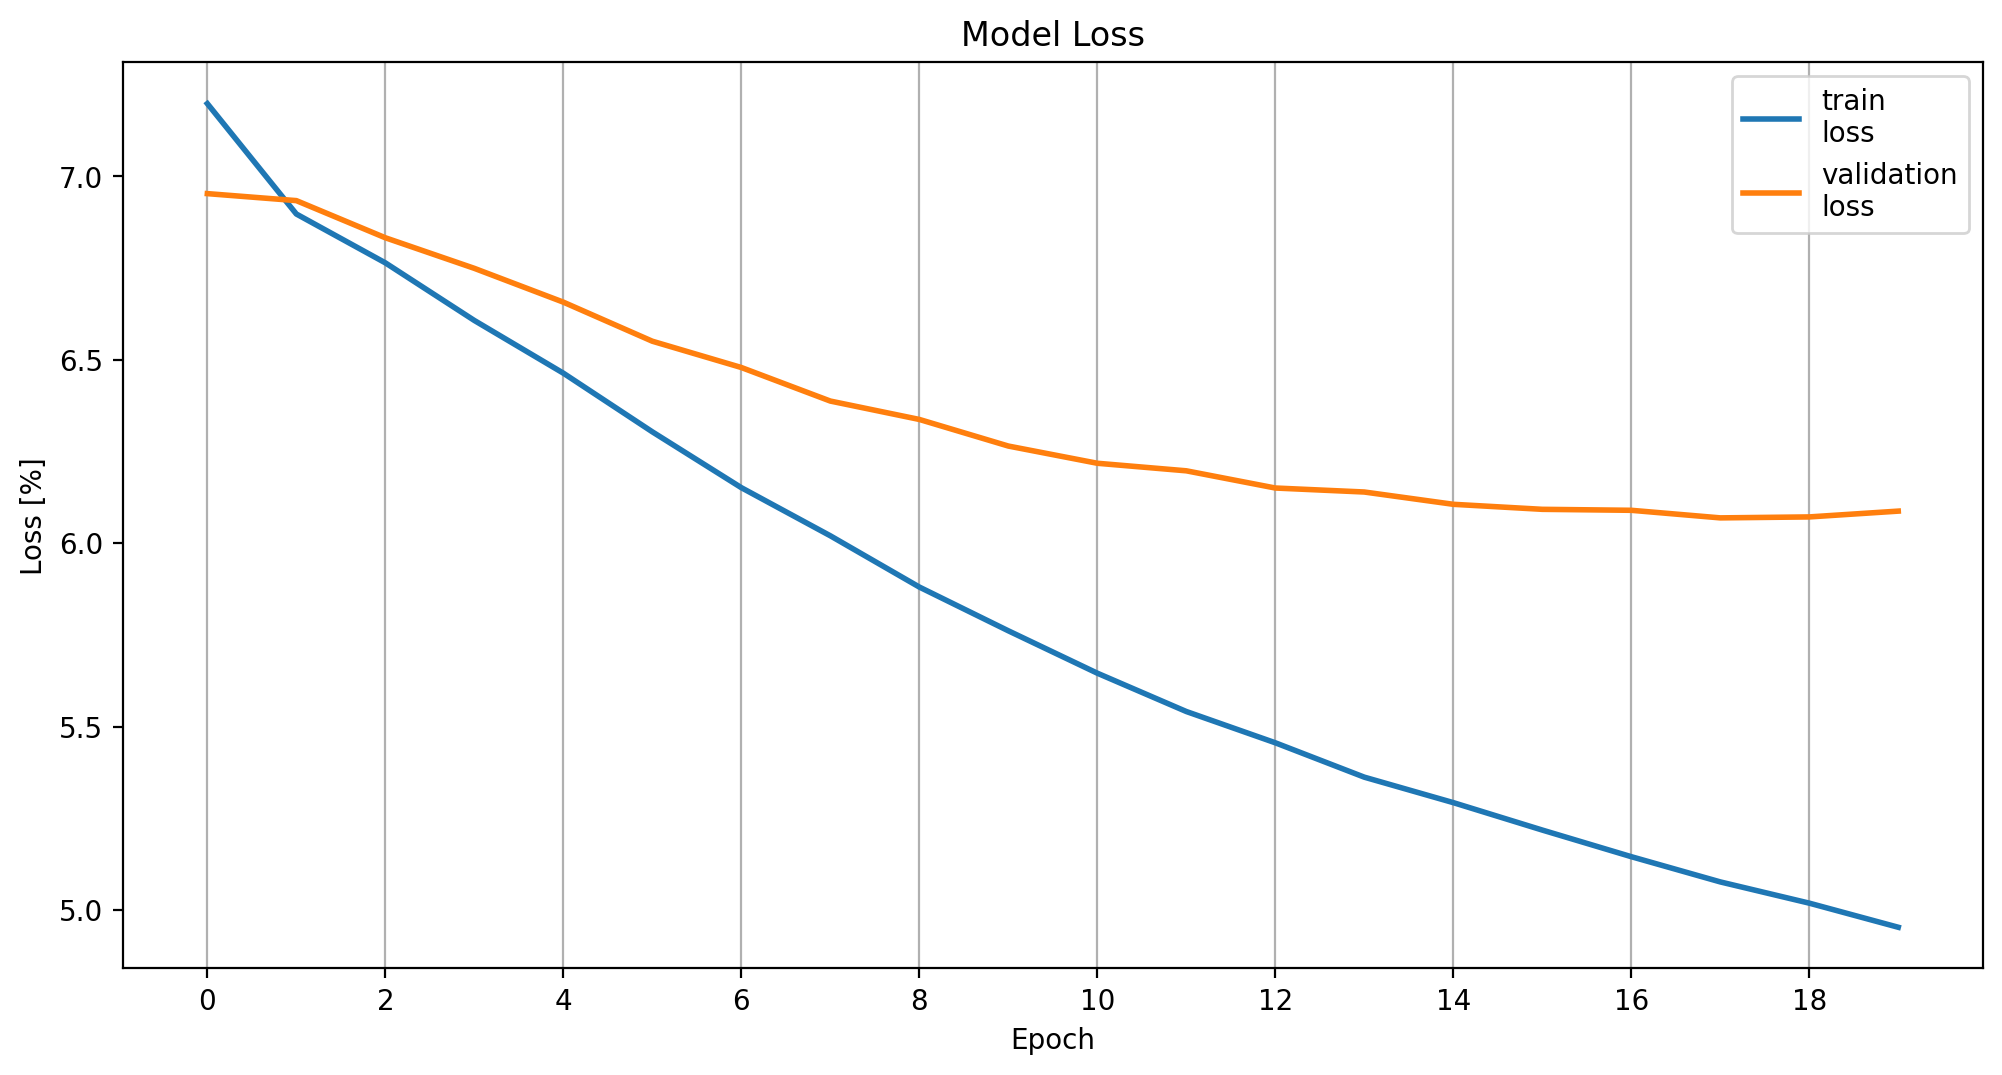

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(12,6), dpi=200)
fig.patch.set_facecolor('white')

# plot accuracy
p1 = ax.plot(trainer.logger['epochs'], trainer.logger['training_loss'], linewidth=2, label='train\nloss')
p2 = ax.plot(trainer.logger['epochs'], trainer.logger['validation_loss'], linewidth=2, label='validation\nloss')
ax.set_xticks(range(0, trainer.logger['epochs'][-1] + 1, 2))
ax.set_xticklabels(range(0, trainer.logger['epochs'][-1] + 1, 2))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss [%]')
ax.set_title('Model Loss')
ax.xaxis.grid()
ax.legend()

In [160]:
# evaluate on test data
test_loss = trainer.evaluate(test_iterator)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

	 Test. Loss: 6.070 |  Test. PPL: 432.810


In [179]:
def predict(model, iterator):
        model.eval()

        with torch.no_grad():
            for i, batch in enumerate(tqdm(iterator)):

                src = batch.text
                trg = batch.summary
                output = model(src, trg, teacher_forcing_ratio=0) #turn off teacher forcing

                #trg = [trg len, batch size]
                #output = [trg len, batch size, output dim]
                print(i)
                print(output.shape)
                
                if i == 0:
                    outputs = torch.argmax(output, -1)
                else:
                    break
                    outputs = torch.cat((outputs, torch.argmax(output, -1)), -1)
                
                # outputs = [trg_len, len(iterator)]
        return torch.transpose(outputs, 0, 1)

In [180]:
test_tensor = predict(model, test_iterator)

0
torch.Size([17, 64, 22260])
1
torch.Size([18, 64, 22260])


In [ ]:
# body = '''
#        Scientists say they have discovered a new species of orangutans on Indonesia’s island of Sumatra.
# The population differs in several ways from the two existing orangutan species found in Sumatra and the neighboring island of Borneo.
# The orangutans were found inside North Sumatra’s Batang Toru forest, the science publication Current Biology reported.
# Researchers named the new species the Tapanuli orangutan. They say the animals are considered a new species because of genetic, skeletal and tooth differences.
# Michael Kruetzen is a geneticist with the University of Zurich who has studied the orangutans for several years. He said he was excited to be part of the unusual discovery of a new great ape in the present day. He noted that most great apes are currently considered endangered or severely endangered.
# Gorillas, chimpanzees and bonobos also belong to the great ape species.
# Orangutan – which means person of the forest in the Indonesian and Malay languages - is the world’s biggest tree-living mammal. The orange-haired animals can move easily among the trees because their arms are longer than their legs. They live more lonely lives than other great apes, spending a lot of time sleeping and eating fruit in the forest.
# The new study said fewer than 800 of the newly-described orangutans exist. Their low numbers make the group the most endangered of all the great ape species.
# They live within an area covering about 1,000 square kilometers. The population is considered highly vulnerable. That is because the environment which they depend on is greatly threatened by development.
# Researchers say if steps are not taken quickly to reduce the current and future threats, the new species could become extinct “within our lifetime.”
# Research into the new species began in 2013, when an orangutan protection group in Sumatra found an injured orangutan in an area far away from the other species. The adult male orangutan had been beaten by local villagers and died of his injuries. The complete skull was examined by researchers.
# Among the physical differences of the new species are a notably smaller head and frizzier hair. The Tapanuli orangutans also have a different diet and are found only in higher forest areas.
# There is no unified international system for recognizing new species. But to be considered, discovery claims at least require publication in a major scientific publication.
# Russell Mittermeier is head of the primate specialist group at the International Union for the Conservation of Nature. He called the finding a “remarkable discovery.” He said it puts responsibility on the Indonesian government to help the species survive.
# Matthew Nowak is one of the writers of the study. He told the Associated Press that there are three groups of the Tapanuli orangutans that are separated by non-protected land.He said forest land needs to connect the separated groups.
# In addition, the writers of the study are recommending that plans for a hydropower center in the area be stopped by the government.
# It also recommended that remaining forest in the Sumatran area where the orangutans live be protected.
# I’m Bryan Lynn.

#         '''


In [74]:
# def plot_results(test_prediction, test_data, n_examples, trg_vocab):
#     for i in range(n_samples):
#         print('TEXT:\n', ' '.join([t for t in test_data.examples[i].text]))
#         print('SUMMARY:\n', ' '.join([t for t in test_data.examples[i].summary]))
#         print('predicted SUMMARY:\n', ' '.join([trg_vocab.itos[t] for t in test_prediction[i]]))
#         print('\n')


In [73]:
# plot_results(test_tensor, test_data, 10, SUMMARY.vocab)

TEXT:
 us technology startup palantir agreed pay 10 crore back wages extend job offers eight applicants settle lawsuit accusing racial discrimination asians . lawsuit specifically focused company hiring selection processes engineering roles . earlier palantir ceo alex karp said ive fcked lot discriminated . <pad> <pad> <pad> <pad> <pad> <pad> <pad>
SUMMARY:
 put air india stake sale 2019 polls swamy <pad> <pad>
predicted SUMMARY:
 <unk> 2 play wedding centurion sena sena shahid shahid 15 plans <eos>


TEXT:
 india organisation chemists druggists declared nationwide strike friday oppose government move regularise online sale medicines . chemists body alleged epharmacies would encourage drug abuse . sale tranquilisers habitforming drugs prohibited online however antidepressants sold without checking prescriptions aiocd said . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
SUMMARY:
 dress made 8 straw hats costs nearly 2 lakh <pad>
predicted SUMMARY:
 <unk> maha drowned kriti

In [182]:
for i in range(30):
    print('TEXT:\n', ' '.join([t for t in test_data.examples[i].text]))
    print('SUMMARY:\n', ' '.join([t for t in test_data.examples[i].summary]))
    print('predicted SUMMARY:\n', ' '.join([SUMMARY.vocab.itos[t] for t in test_tensor[i]]))
    print('\n')

TEXT:
 a student found â£100 ( â¹9 , 000 ) on her lap on a train in england when she woke up from a nap after discussing her financial problems with her mother on the phone . in a facebook post , the student revealed that she had talked about failing to locate â£35 . the conversation was apparently overheard by a stranger who left her the money .
SUMMARY:
 stranger overhears student ' s money issues , leaves her â¹9 , 000
predicted SUMMARY:
 <unk> man dies after car , s , ' to ' to ' <eos> <eos> <eos> <eos>


TEXT:
 classified files related to former us president john f kennedy ' s assassination have revealed that his assassin lee harvey oswald was in contact with then-soviet intelligence services . the files further revealed that oswald had met a soviet assassination agent about two months before kennedy ' s killing . soviet officials also feared a war in the wake of kennedy ' s assassination , the files stated .
SUMMARY:
 kennedy ' s assassin had links to soviet union jfk files
pre